# Start

In [ ]:
# !pip install --upgrade pip

In [1]:
# **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
stable = False # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null
from tsai.all import *
computer_setup()

  Running command git clone --filter=blob:none --quiet https://github.com/timeseriesAI/tsai.git /tmp/pip-req-build-ban1j2md
os              : Linux-4.18.0-240.el8.x86_64-x86_64-with-redhat-8.3-Ootpa
python          : 3.7.13
tsai            : 0.3.6
fastai          : 2.7.9
fastcore        : 1.5.27
torch           : 1.12.1+cu102
device          : 8 gpus (['Tesla V100-SXM2-16GB', 'Tesla V100-SXM2-16GB', 'Tesla V100-SXM2-16GB', 'Tesla V100-SXM2-16GB', 'Tesla V100-SXM2-16GB', 'Tesla V100-SXM2-16GB', 'Tesla V100-SXM2-16GB', 'Tesla V100-SXM2-16GB'])
cpu cores       : 36
threads per cpu : 1
RAM             : 1511.55 GB
GPU memory      : [15.78, 15.78, 15.78, 15.78, 15.78, 15.78, 15.78, 15.78] GB


In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
cd '/home/mohamed.ahajjam/corrections/'

/home/mohamed.ahajjam/corrections


 # **CONFIGURATION**

In [3]:
# CONFIGURATION
model_name  = InceptionTimePlus#
par = {}#'levels':4, 'base_arch': InceptionTimePlus}#,  'wavelet': 'db4'}#, 'base_arch':InceptionTime'}#'hidden_size':[100, 50], 'n_layers':2}#{'levels':4}, 'wavelet': None, 'base_arch': InceptionTimePlus}#,  'wavelet': 'db4'}#, 'base_arch':InceptionTime}
ind = ''
freeze_epoch = 25
IMFS_count = 31
split_indx = 30
location = 'Nome'
season1 = 'bothSeasons' + location

***************** Model: PatchTST
splitting data..
Standardizing data..
training set:  (10732, 2, 30) (10732, 7) , testing set:  (2682, 2, 30) (2682, 7)


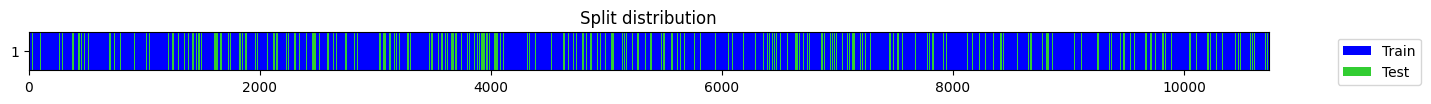

RuntimeError: The size of tensor a (14588) must match the size of tensor b (7294) at non-singleton dimension 0

In [6]:
location = 'Nome'

#No decomposition 
ind = ''
ind2 = ''
mode = 'T2Q2_'

models = {'PatchTST'}#'TSTPlus','XCMPlus','LSTMPlus','GRUPlus','MiniRocketPlus'}

for key in models:
    exec('model_name = {}'.format(key))      

    print('***************** Model: %s' % model_name.__name__)
    season1 = 'bothSeasons'+ location
    T2 = pd.read_csv('TF7d_T2sequences_' + season1 + '.csv',header=None)
    Q2 = pd.read_csv('TF7d_Q2sequences_' + season1 + '.csv',header=None)
    T2

    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    col = ['Signal']
    row = ["feature{}".format(x) for x in np.array(range(10))] #Change this number to higher if necessary!
    scalersIN = pd.DataFrame([], columns = col, index = row)
    scalersOUT = pd.DataFrame([], columns = col, index = [0])
    from sklearn.preprocessing import OrdinalEncoder

    test_targetdata={}
    test_predsdata={}

    test_targetdata={}
    test_predsdata={}

    print('splitting data..')
    T2_data = to3d(T2.iloc[:,:].values)
    Q2_data = to3d(Q2.iloc[:,:].values)
    data = np.concatenate([T2_data, Q2_data],axis=1)  #, TS_Mend, TS_Mstart
    data_X = data[:,:,:split_indx]
    data_y = data[:,0,split_indx:]
    X_train, X_test = data_X[:T2.shape[0]-int(T2.shape[0]*20/100)], data_X[-int(T2.shape[0]*20/100):]
    y_train, y_test = data_y[:T2.shape[0]-int(T2.shape[0]*20/100)], data_y[-int(T2.shape[0]*20/100):]
    print('Standardizing data..')
    for i in range(X_train.shape[1]): #normalize IN data
      scalersIN['Signal']["feature{}".format(i)] = StandardScaler()
      X_train[:, i, :] = scalersIN['Signal']["feature{}".format(i)].fit_transform(X_train[:, i, :])    
    scalersOUT['Signal'] = StandardScaler() #normalize OUT data
    y_train = scalersOUT['Signal'][0].fit_transform(y_train)  
    print('training set: ',X_train.shape, y_train.shape, ', testing set: ',X_test.shape, y_test.shape)

    splits = get_splits(y_train, valid_size=.2, stratify=False, random_state=42, shuffle=True)
    tfms  = [None, [ToFloat(), ToNumpyTensor()]]
    dsets = TSDatasets(X_train, y_train, tfms=tfms, splits=splits, inplace=True)
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])    
    par = {}
    #Model learning
    learn = TSForecaster(X_train, y_train, splits=splits, tfms=tfms, bs=1042, arch=model_name, arch_config=par, metrics=[mae, rmse], cbs=[ShowGraph(),SaveModel()])
    lr = learn.lr_find()   
    learning_rate = lr.valley
    learn.fit_one_cycle(freeze_epoch, learning_rate)
    valid_dl = dls.valid

    # Labeled test data
    for i in range(X_test.shape[1]): #normalize IN data
      X_test[:, i, :] = scalersIN['Signal']["feature{}".format(i)].transform(X_test[:, i, :])    
    y_test = scalersOUT['Signal'][0].transform(y_test)  
    test_ds = valid_dl.dataset.add_test(X_test, y_test)
    test_dl = valid_dl.new(test_ds)
    _, temp_targets, temp_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
    #denormalize data
    test_predsdata = scalersOUT['Signal'][0].inverse_transform(temp_preds)  
    test_targetdata = scalersOUT['Signal'][0].inverse_transform(temp_targets)    
    del temp_targets, temp_preds
    # RMSE.append(rmse(test_targetdata["test_targets"+str(x)].data, test_predsdata["test_preds"+str(x)].data))
    # MAE.append(mae(test_targetdata["test_targets"+str(x)].data, test_predsdata["test_preds"+str(x)].data))
    # print(f'RMSE: {RMSE[x]:10.6f}, MAE: {MAE[x]:10.6f}')
    d = pd.DataFrame([])
    d = test_targetdata
    np.savetxt('export2/test_targetdata_TF7d_' + mode + model_name.__name__ + ind + '_' + ind2 + '_' + season1 + '.csv', d, delimiter=',')
    dp = pd.DataFrame([])
    dp = test_predsdata
    np.savetxt('export2/test_predsdata_TF7d_' + mode + model_name.__name__ + ind + '_' + ind2 + '_' + season1 + '.csv', dp, delimiter=',')


***************** Model: TSiTPlus
splitting data..
Standardizing data..
training set:  (10732, 2, 30) (10732, 7) , testing set:  (2682, 2, 30) (2682, 7)


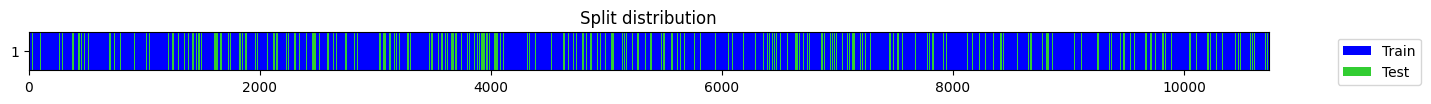

use_token set to False as c_out == 1


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [46]:
location = 'Bethel'

#No decomposition 
ind = ''
ind2 = ''
mode = 'T2Q2_'

models = {'TSTPlus','XCMPlus','LSTMPlus','GRUPlus','MiniRocketPlus'}

for key in models:
    exec('model_name = {}'.format(key))      

    print('***************** Model: %s' % model_name.__name__)
    season1 = 'bothSeasons'+ location
    T2 = pd.read_csv('TF7d_T2sequences_' + season1 + '.csv',header=None)
    Q2 = pd.read_csv('TF7d_Q2sequences_' + season1 + '.csv',header=None)
    T2

    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    col = ['Signal']
    row = ["feature{}".format(x) for x in np.array(range(10))] #Change this number to higher if necessary!
    scalersIN = pd.DataFrame([], columns = col, index = row)
    scalersOUT = pd.DataFrame([], columns = col, index = [0])
    from sklearn.preprocessing import OrdinalEncoder

    test_targetdata={}
    test_predsdata={}

    test_targetdata={}
    test_predsdata={}

    print('splitting data..')
    T2_data = to3d(T2.iloc[:,:].values)
    Q2_data = to3d(Q2.iloc[:,:].values)
    data = np.concatenate([T2_data, Q2_data],axis=1)  #, TS_Mend, TS_Mstart
    data_X = data[:,:,:split_indx]
    data_y = data[:,0,split_indx:]
    X_train, X_test = data_X[:T2.shape[0]-int(T2.shape[0]*20/100)], data_X[-int(T2.shape[0]*20/100):]
    y_train, y_test = data_y[:T2.shape[0]-int(T2.shape[0]*20/100)], data_y[-int(T2.shape[0]*20/100):]
    print('Standardizing data..')
    for i in range(X_train.shape[1]): #normalize IN data
      scalersIN['Signal']["feature{}".format(i)] = StandardScaler()
      X_train[:, i, :] = scalersIN['Signal']["feature{}".format(i)].fit_transform(X_train[:, i, :])    
    scalersOUT['Signal'] = StandardScaler() #normalize OUT data
    y_train = scalersOUT['Signal'][0].fit_transform(y_train)  
    print('training set: ',X_train.shape, y_train.shape, ', testing set: ',X_test.shape, y_test.shape)

    splits = get_splits(y_train, valid_size=.2, stratify=False, random_state=42, shuffle=True)
    tfms  = [None, [ToFloat(), ToNumpyTensor()]]
    dsets = TSDatasets(X_train, y_train, tfms=tfms, splits=splits, inplace=True)
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])    
    par = {}
    #Model learning
    learn = TSForecaster(X_train, y_train, splits=splits, tfms=tfms, bs=1042, arch=model_name, arch_config=par, metrics=[mae, rmse], cbs=[ShowGraph(),SaveModel()])
    lr = learn.lr_find()   
    learning_rate = lr.valley
    learn.fit_one_cycle(freeze_epoch, learning_rate)
    valid_dl = dls.valid

    # Labeled test data
    for i in range(X_test.shape[1]): #normalize IN data
      X_test[:, i, :] = scalersIN['Signal']["feature{}".format(i)].transform(X_test[:, i, :])    
    y_test = scalersOUT['Signal'][0].transform(y_test)  
    test_ds = valid_dl.dataset.add_test(X_test, y_test)
    test_dl = valid_dl.new(test_ds)
    _, temp_targets, temp_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
    #denormalize data
    test_predsdata = scalersOUT['Signal'][0].inverse_transform(temp_preds)  
    test_targetdata = scalersOUT['Signal'][0].inverse_transform(temp_targets)    
    del temp_targets, temp_preds
    # RMSE.append(rmse(test_targetdata["test_targets"+str(x)].data, test_predsdata["test_preds"+str(x)].data))
    # MAE.append(mae(test_targetdata["test_targets"+str(x)].data, test_predsdata["test_preds"+str(x)].data))
    # print(f'RMSE: {RMSE[x]:10.6f}, MAE: {MAE[x]:10.6f}')
    d = pd.DataFrame([])
    d = test_targetdata
    np.savetxt('export2/test_targetdata_TF7d_' + mode + model_name.__name__ + ind + '_' + ind2 + '_' + season1 + '.csv', d, delimiter=',')
    dp = pd.DataFrame([])
    dp = test_predsdata
    np.savetxt('export2/test_predsdata_TF7d_' + mode + model_name.__name__ + ind + '_' + ind2 + '_' + season1 + '.csv', dp, delimiter=',')


***************** Model: TSTPlus
splitting data..
Standardizing data..
training set:  (10732, 2, 30) (10732, 7) , testing set:  (2682, 2, 30) (2682, 7)


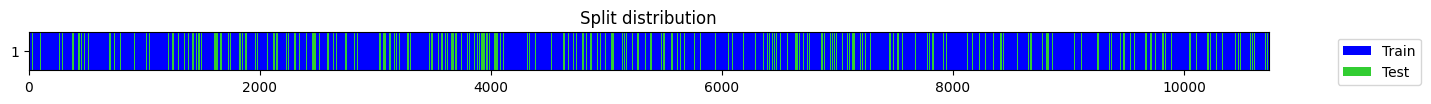

epoch,train_loss,valid_loss,mae,_rmse,time
0,1.467366,1.419101,1.032205,1.191260,00:00
1,1.317808,1.012200,0.857826,1.006081,00:00
2,1.080556,0.514763,0.592953,0.717470,00:00
3,0.852896,0.300140,0.434908,0.547851,00:00
4,0.706131,0.293519,0.432392,0.541774,00:00
5,0.597706,0.246355,0.390576,0.496342,00:00
6,0.513575,0.223967,0.370266,0.473251,00:00
7,0.449337,0.207149,0.352311,0.455136,00:00
8,0.399149,0.198532,0.343703,0.445570,00:00
9,0.359277,0.192100,0.337485,0.438292,00:00


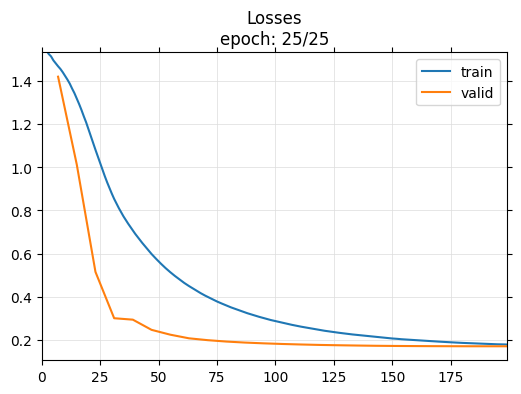

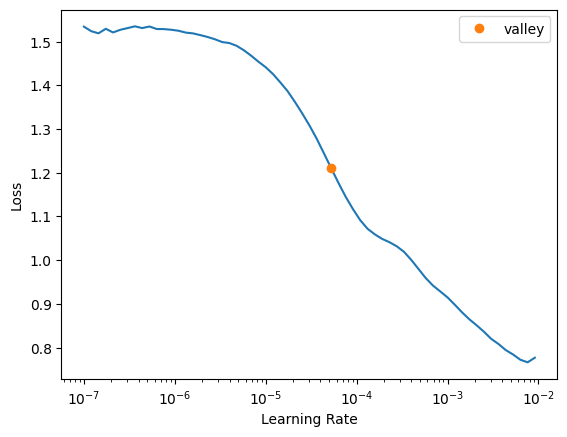

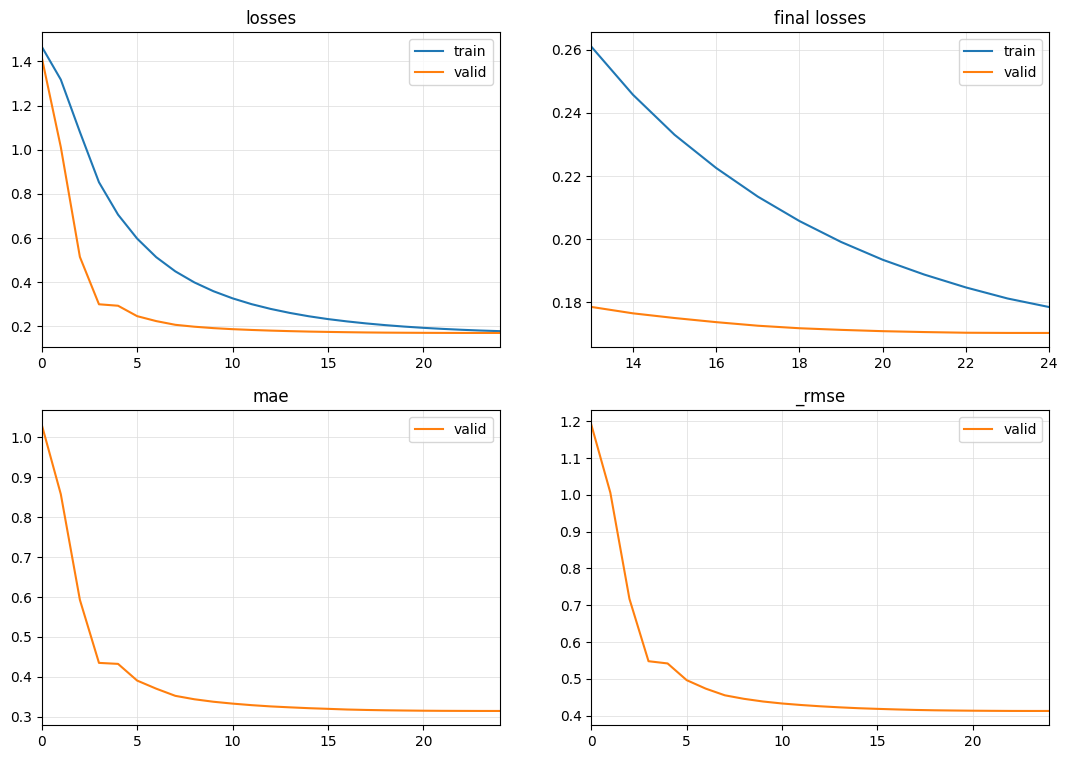

***************** Model: LSTMPlus
splitting data..
Standardizing data..
training set:  (10732, 2, 30) (10732, 7) , testing set:  (2682, 2, 30) (2682, 7)


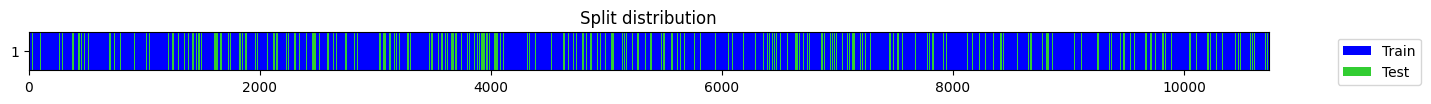

epoch,train_loss,valid_loss,mae,_rmse,time
0,1.007640,0.951604,0.856943,0.975502,00:00
1,0.966005,0.832286,0.798391,0.912297,00:00
2,0.885777,0.605297,0.672878,0.778009,00:00
3,0.759858,0.329685,0.470321,0.574182,00:00
4,0.637303,0.321364,0.465080,0.566890,00:00
5,0.554031,0.273588,0.423741,0.523057,00:00
6,0.491992,0.266936,0.417259,0.516658,00:00
7,0.444237,0.259902,0.410907,0.509805,00:00
8,0.407020,0.250859,0.403233,0.500858,00:00
9,0.376748,0.244391,0.396318,0.494360,00:00


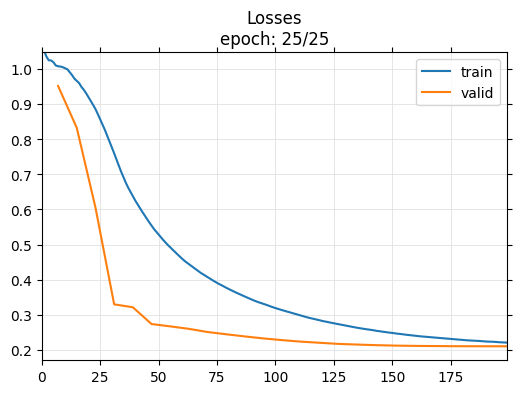

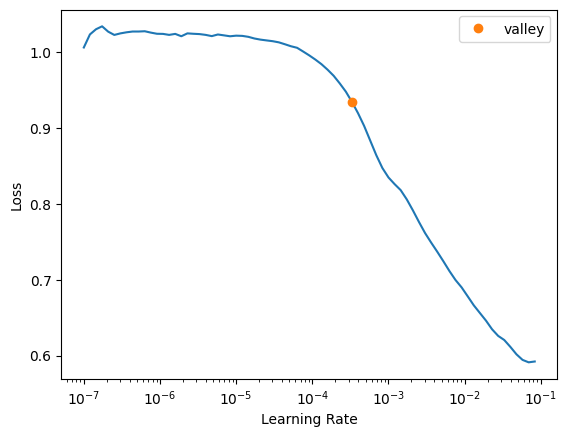

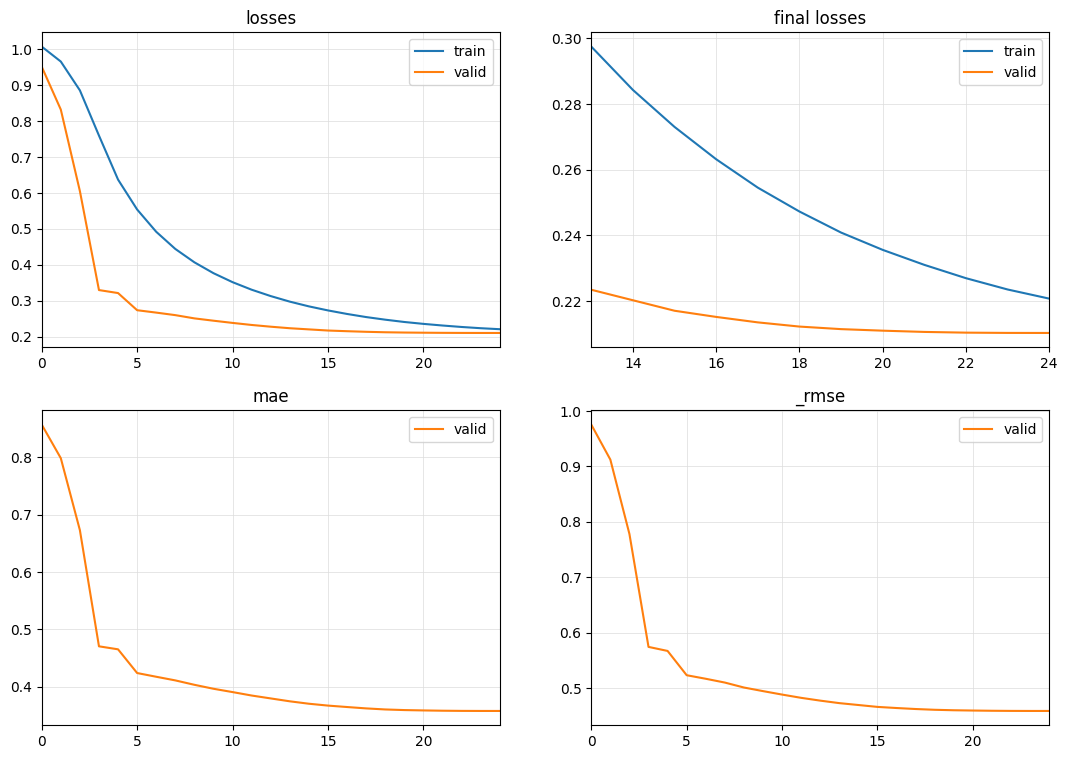

***************** Model: MiniRocketPlus
splitting data..
Standardizing data..
training set:  (10732, 2, 30) (10732, 7) , testing set:  (2682, 2, 30) (2682, 7)


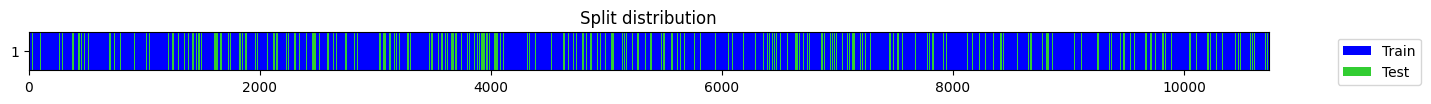

epoch,train_loss,valid_loss,mae,_rmse,time
0,1.121036,1.055995,0.889347,1.027616,00:00
1,1.090554,0.989062,0.869795,0.994516,00:00
2,1.052933,0.938536,0.848381,0.968780,00:00
3,1.016186,0.867993,0.812034,0.931661,00:00
4,0.968643,0.758576,0.757357,0.870963,00:00
5,0.912379,0.654649,0.698876,0.809103,00:00
6,0.850786,0.566438,0.643151,0.752621,00:00
7,0.788326,0.492348,0.593503,0.701675,00:00
8,0.727952,0.433739,0.550847,0.658588,00:00
9,0.671357,0.387923,0.514544,0.622835,00:00


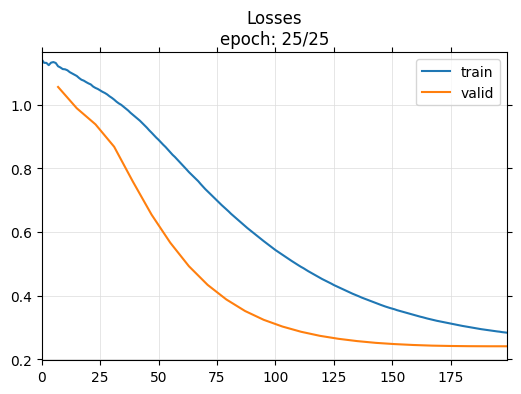

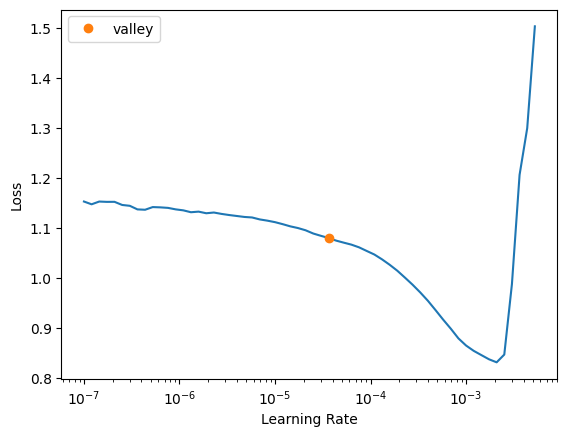

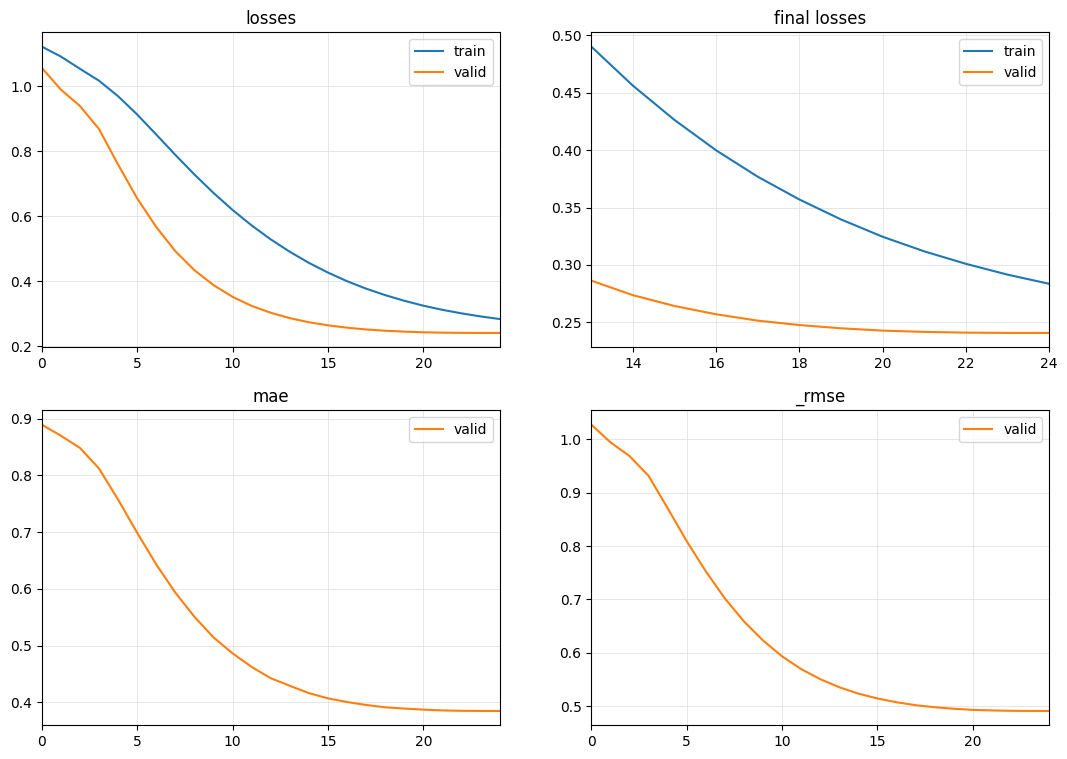

***************** Model: XCMPlus
splitting data..
Standardizing data..
training set:  (10732, 2, 30) (10732, 7) , testing set:  (2682, 2, 30) (2682, 7)


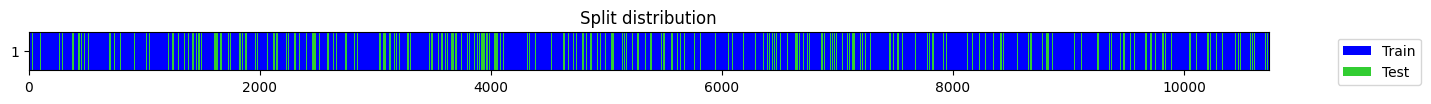

epoch,train_loss,valid_loss,mae,_rmse,time
0,1.150043,0.975268,0.868132,0.987556,00:00
1,1.091927,0.945735,0.852897,0.972489,00:00
2,0.990962,0.832361,0.794504,0.912338,00:00
3,0.854841,0.585212,0.651057,0.764992,00:00
4,0.721494,0.349680,0.482776,0.591338,00:00
5,0.618698,0.267411,0.414422,0.517118,00:00
6,0.537695,0.233994,0.383913,0.483729,00:00
7,0.472158,0.216475,0.364254,0.465268,00:00
8,0.419369,0.205344,0.352122,0.453149,00:00
9,0.376799,0.200452,0.345918,0.447719,00:00


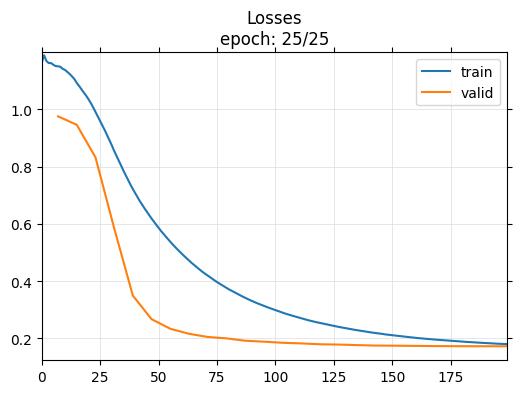

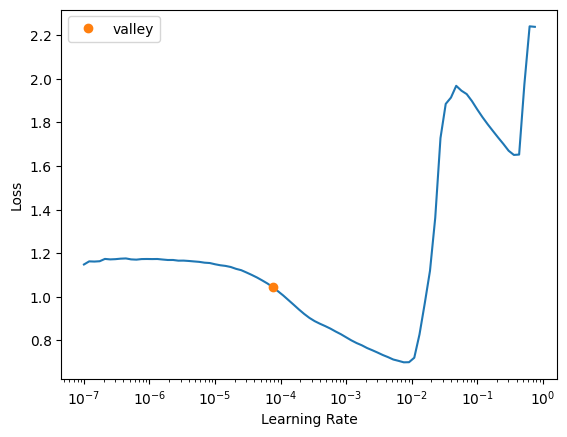

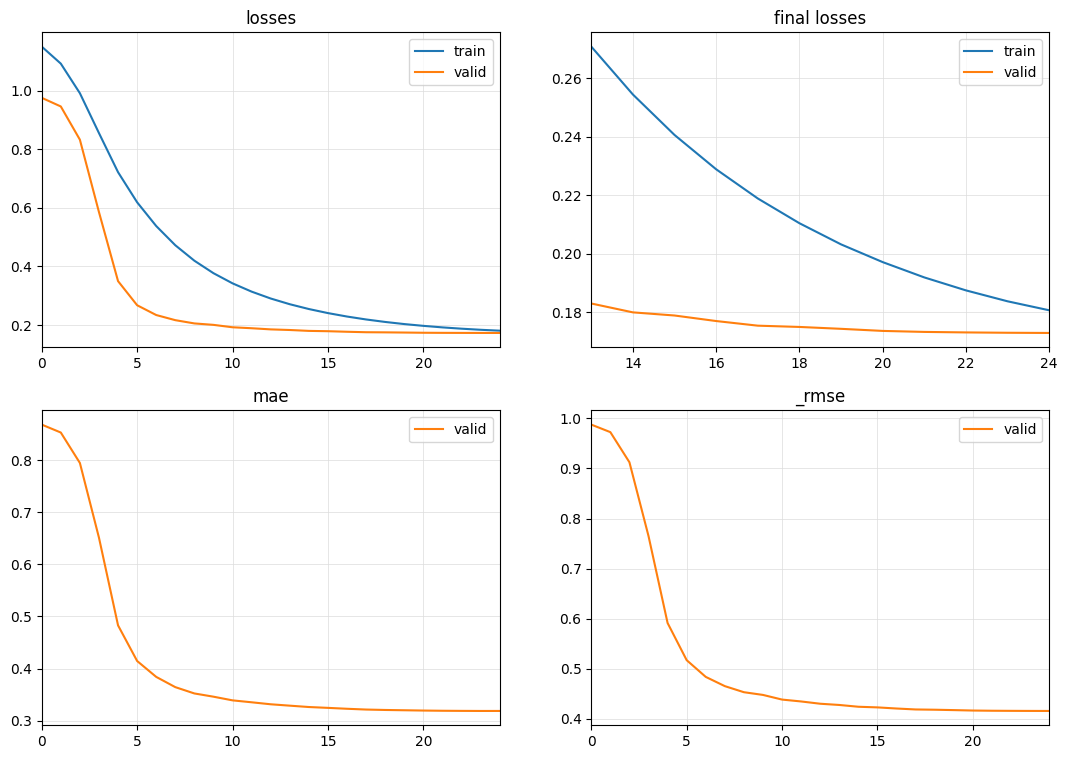

***************** Model: GRUPlus
splitting data..
Standardizing data..
training set:  (10732, 2, 30) (10732, 7) , testing set:  (2682, 2, 30) (2682, 7)


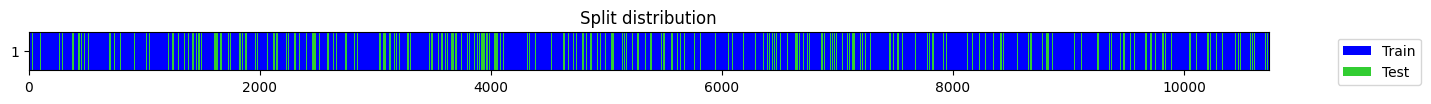

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.969099,0.894367,0.828668,0.945710,00:00
1,0.897079,0.701250,0.727905,0.837407,00:00
2,0.774477,0.404466,0.531291,0.635976,00:00
3,0.633052,0.299587,0.449050,0.547345,00:00
4,0.544904,0.277264,0.429589,0.526559,00:00
5,0.477538,0.262597,0.413723,0.512442,00:00
6,0.428100,0.247839,0.401288,0.497834,00:00
7,0.389631,0.238724,0.392531,0.488594,00:00
8,0.358771,0.229476,0.382236,0.479036,00:00
9,0.333414,0.222029,0.374228,0.471199,00:00


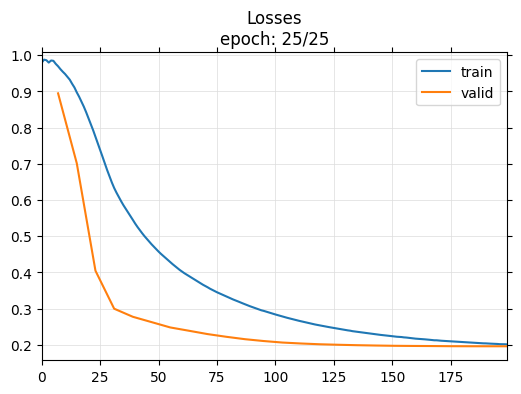

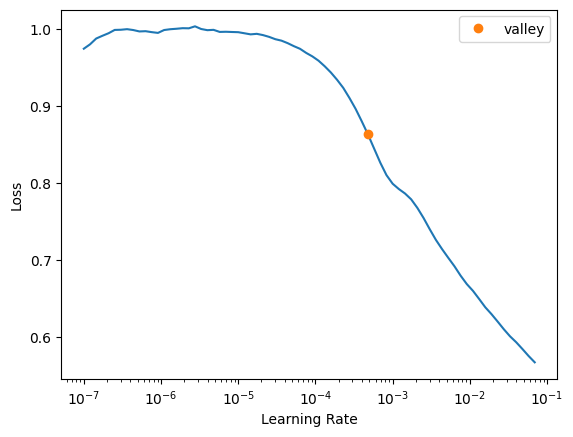

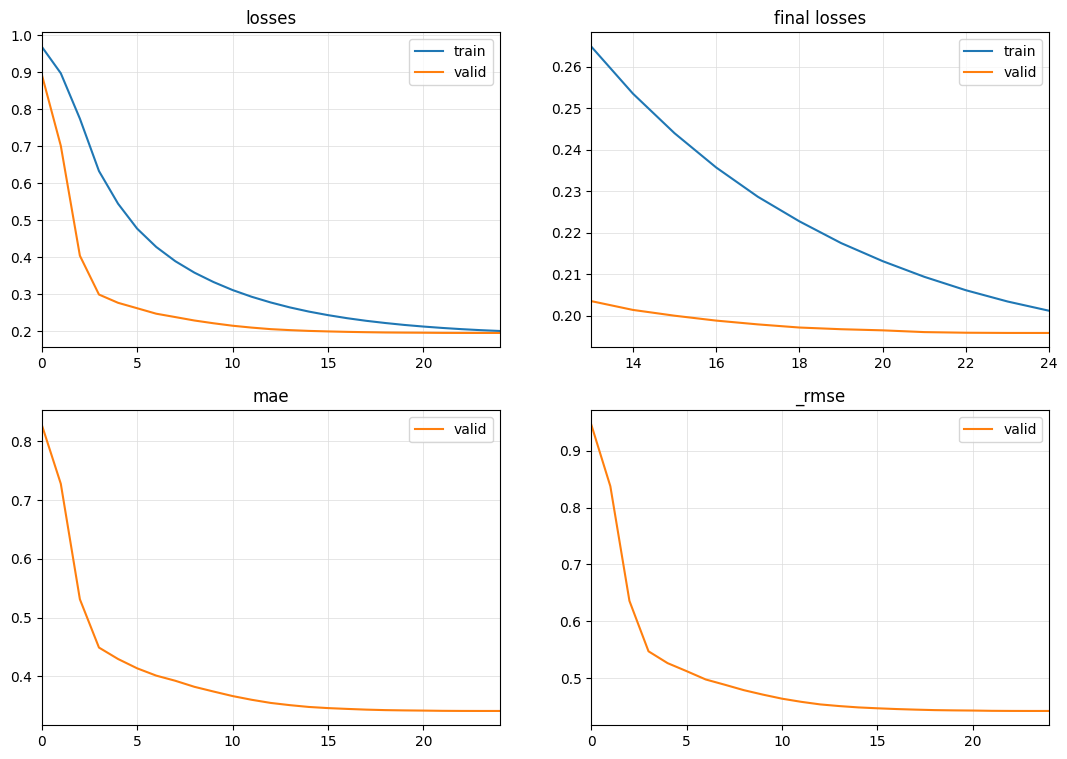

***************** Model: PatchTST
splitting data..
Standardizing data..
training set:  (10732, 2, 30) (10732, 7) , testing set:  (2682, 2, 30) (2682, 7)


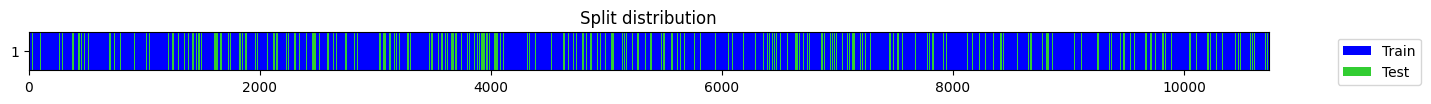

RuntimeError: The size of tensor a (14588) must match the size of tensor b (7294) at non-singleton dimension 0

In [43]:
location = 'Utqiagvik'

#No decomposition 
ind = ''
ind2 = ''
mode = 'T2Q2_'

models = {'TSTPlus','XCMPlus','LSTMPlus','GRUPlus','MiniRocketPlus'}

for key in models:
    exec('model_name = {}'.format(key))      

    print('***************** Model: %s' % model_name.__name__)
    season1 = 'bothSeasons'+ location
    T2 = pd.read_csv('TF7d_T2sequences_' + season1 + '.csv',header=None)
    Q2 = pd.read_csv('TF7d_Q2sequences_' + season1 + '.csv',header=None)
    T2

    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    col = ['Signal']
    row = ["feature{}".format(x) for x in np.array(range(10))] #Change this number to higher if necessary!
    scalersIN = pd.DataFrame([], columns = col, index = row)
    scalersOUT = pd.DataFrame([], columns = col, index = [0])
    from sklearn.preprocessing import OrdinalEncoder

    test_targetdata={}
    test_predsdata={}

    test_targetdata={}
    test_predsdata={}

    print('splitting data..')
    T2_data = to3d(T2.iloc[:,:].values)
    Q2_data = to3d(Q2.iloc[:,:].values)
    data = np.concatenate([T2_data, Q2_data],axis=1)  #, TS_Mend, TS_Mstart
    data_X = data[:,:,:split_indx]
    data_y = data[:,0,split_indx:]
    X_train, X_test = data_X[:T2.shape[0]-int(T2.shape[0]*20/100)], data_X[-int(T2.shape[0]*20/100):]
    y_train, y_test = data_y[:T2.shape[0]-int(T2.shape[0]*20/100)], data_y[-int(T2.shape[0]*20/100):]
    print('Standardizing data..')
    for i in range(X_train.shape[1]): #normalize IN data
      scalersIN['Signal']["feature{}".format(i)] = StandardScaler()
      X_train[:, i, :] = scalersIN['Signal']["feature{}".format(i)].fit_transform(X_train[:, i, :])    
    scalersOUT['Signal'] = StandardScaler() #normalize OUT data
    y_train = scalersOUT['Signal'][0].fit_transform(y_train)  
    print('training set: ',X_train.shape, y_train.shape, ', testing set: ',X_test.shape, y_test.shape)

    splits = get_splits(y_train, valid_size=.2, stratify=False, random_state=42, shuffle=True)
    tfms  = [None, [ToFloat(), ToNumpyTensor()]]
    dsets = TSDatasets(X_train, y_train, tfms=tfms, splits=splits, inplace=True)
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])    
    par = {}
    #Model learning
    learn = TSForecaster(X_train, y_train, splits=splits, tfms=tfms, bs=1042, arch=model_name, arch_config=par, metrics=[mae, rmse], cbs=[ShowGraph(),SaveModel()])
    lr = learn.lr_find()   
    learning_rate = lr.valley
    learn.fit_one_cycle(freeze_epoch, learning_rate)
    valid_dl = dls.valid

    # Labeled test data
    for i in range(X_test.shape[1]): #normalize IN data
      X_test[:, i, :] = scalersIN['Signal']["feature{}".format(i)].transform(X_test[:, i, :])    
    y_test = scalersOUT['Signal'][0].transform(y_test)  
    test_ds = valid_dl.dataset.add_test(X_test, y_test)
    test_dl = valid_dl.new(test_ds)
    _, temp_targets, temp_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
    #denormalize data
    test_predsdata = scalersOUT['Signal'][0].inverse_transform(temp_preds)  
    test_targetdata = scalersOUT['Signal'][0].inverse_transform(temp_targets)    
    del temp_targets, temp_preds
    # RMSE.append(rmse(test_targetdata["test_targets"+str(x)].data, test_predsdata["test_preds"+str(x)].data))
    # MAE.append(mae(test_targetdata["test_targets"+str(x)].data, test_predsdata["test_preds"+str(x)].data))
    # print(f'RMSE: {RMSE[x]:10.6f}, MAE: {MAE[x]:10.6f}')
    d = pd.DataFrame([])
    d = test_targetdata
    np.savetxt('export2/test_targetdata_TF7d_' + mode + model_name.__name__ + ind + '_' + ind2 + '_' + season1 + '.csv', d, delimiter=',')
    dp = pd.DataFrame([])
    dp = test_predsdata
    np.savetxt('export2/test_predsdata_TF7d_' + mode + model_name.__name__ + ind + '_' + ind2 + '_' + season1 + '.csv', dp, delimiter=',')
